In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
len(mnist.test.images)

10000

In [4]:
import tensorflow as tf
import numpy as np

In [5]:
D = 784
x = tf.placeholder(tf.float32, [None, D])

In [6]:
W = tf.Variable(tf.zeros([D, 10]))
b = tf.Variable(tf.zeros([10]))

In [7]:
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 10])

# Solution from Tutorial

In [8]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [9]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [10]:
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [11]:
# tf.argmax(y,1) - what we predicted
# tf.argmax(y_,1) - correct label
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9179


# Custom solution

See: https://github.com/pilipolio/schibsted-study/blob/master/notebooks/201612_mnist.ipynb

### Task
* Re-user softmax classification from https://github.com/pilipolio/schibsted-study/blob/master/notebooks/201611_multiclass_classification.ipynb
* Define train_X and train_Y from mnist_data.train.images/labels
* Calculate the accuracy (ratio of correctly classified labels)
* Think about a way to visualise the fitted weights
* Improve the accuracy of the naive model by adding non-linear layers (see https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html)

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

WIDTH, HEIGHT = (28, 28)

# unique_labels = np.unique(mnist.train.labels)
unique_labels = 10
# print('Train has {} dimensions with {} unique classe: {}'.format(mnist.train.images.shape, len(unique_labels), unique_labels))

In [13]:
n_samples, D = mnist.train.images.shape
C = unique_labels #.shape[0]

n_samples, D, C

(55000, 784, 10)

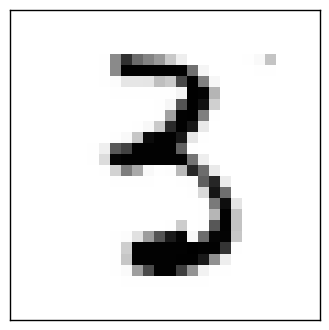

In [14]:
def show_image(pixels):
    plt.imshow(pixels.reshape((WIDTH, HEIGHT)), cmap='Greys', interpolation='None');
    plt.xticks([]); plt.yticks([]);

show_image(mnist.train.images[0])

In [15]:
# Parameters
learning_rate = .5
n_epochs = 1000
display_step = 100

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
init = tf.initialize_all_variables()

In [16]:
# storing weights for each epochs for later visualisation
fitted_ws = np.zeros((n_epochs, D * unique_labels))

for epoch in range(n_epochs):

    batch_xs, batch_ys = mnist.train.next_batch(100)
    # batch_xs = mnist.train.images
    # batch_ys = mnist.train.labels
    _, fitted_w, loss_value, predicted_probs = sess.run(
        fetches=[optimizer, W, cross_entropy, y],
        feed_dict={x: batch_xs, y_: batch_ys})
    fitted_ws[epoch, :] = fitted_w.ravel()
    predicted_probs = sess.run(y, feed_dict={x: batch_xs})
    predicted_classes = predicted_probs.argmax(axis=1)
    n_correct_samples = np.sum(predicted_classes == batch_ys.argmax(axis=1))
    percent_correct = round(n_correct_samples / len(predicted_classes) * 100)
    
    if (epoch) % display_step == 0:
        print("Epoch: {:4d}, cost={:.4f}, %correct {}".format(epoch, loss_value, percent_correct))

Epoch:    0, cost=0.3913, %correct 93.0
Epoch:  100, cost=0.1394, %correct 98.0
Epoch:  200, cost=0.4720, %correct 91.0
Epoch:  300, cost=0.1726, %correct 97.0
Epoch:  400, cost=0.1996, %correct 95.0
Epoch:  500, cost=0.3291, %correct 93.0
Epoch:  600, cost=0.2684, %correct 93.0
Epoch:  700, cost=0.3076, %correct 91.0
Epoch:  800, cost=0.4067, %correct 92.0
Epoch:  900, cost=0.4118, %correct 89.0


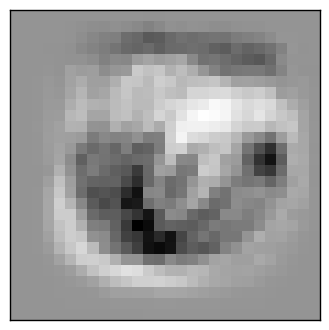

In [17]:
w_images = fitted_ws[-1].reshape((D, 10))
show_image(w_images[:,6])

In [18]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9233


# Conv-net solution using TF Slim

In [19]:
import tensorflow.contrib.slim as slim

In [20]:
def lenet(images):
   net = slim.layers.conv2d(images, 20, [5,5], scope='conv1')
   net = slim.layers.max_pool2d(net, [2,2], scope='pool1')
   net = slim.layers.conv2d(net, 50, [5,5], scope='conv2')
   net = slim.layers.max_pool2d(net, [2,2], scope='pool2')
   net = slim.layers.flatten(net, scope='flatten3')
   net = slim.layers.fully_connected(net, 500, scope='fully_connected4')
   net = slim.layers.fully_connected(net, 10, activation_fn=None, scope='fully_connected5')
   return net

In [23]:
mnist.train.images.reshape((-1, HEIGHT, WIDTH, 1)).shape

(55000, 28, 28, 1)

In [24]:
images = mnist.train.images.reshape((-1, HEIGHT, WIDTH, 1))
net = lenet(images)

In [29]:
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(net, mnist.train.labels)

ValueError: ('Rank mismatch: Labels rank (received %s) should equal logits rank (received %s) - 1.', 2, 2)